# Non-Deterministic Preparation of Cat States

Cat states are of quantum states of the form $|0\rangle^{\otimes w}+|1\rangle^{\otimes w}$ which have various application in quantum error correction, most famously in Shor-style syndrome extraction where a weight-$w$ stabilizer on a code is measured by performing a transversal CNOT from the support of the stabilizer to a cat state. The difficulty of cat states comes from the fact that it is hard to prepare them in a fault-tolerant manner. If we use cat states for syndrome extraction we want them to be as high-quality as possible.

## Non-Fault-tolerant Preparation Circuit
A cat state can be prepared by preparing one (arbitrary) qubit in the $|+\rangle$ state and the remaining $w-1$ in the $|0\rangle$ state and then entangle the $|+\rangle$ state with the remaining qubits via CNOT gates. The exact pattern is of these CNOTs is not too important. We just have to make sure that the entanglement spreads to every qubit.

One way to do it is by arranging the CNOTs as a perfect balanced binary tree which prepares the state in $\log_2{w}$ depth. Let's define a noisy stim_circuit that does this.

In [1]:
import stim
import numpy as np
import matplotlib.pyplot as plt

circ = stim.Circuit()
p = 0.05 # physical error rate

def noisy_cnot(circ: stim.Circuit, ctrl: int, trgt: int, p: float) -> None:
    circ.append_operation("CX", [ctrl, trgt])
    circ.append_operation("DEPOLARIZE2", [ctrl, trgt], p)

circ.append_operation("H", [0])
circ.append_operation("DEPOLARIZE1", [0], p)

noisy_cnot(circ, 0, 4, p)

noisy_cnot(circ, 0, 2, p)
noisy_cnot(circ, 4, 6, p)

noisy_cnot(circ, 0, 1, p)
noisy_cnot(circ, 2, 3, p)
noisy_cnot(circ, 4, 5, p)
noisy_cnot(circ, 6, 7, p)

circ.to_crumble_url()

'https://algassert.com/crumble#circuit=H_0;DEPOLARIZE1(0.05)0;CX_0_4;DEPOLARIZE2(0.05)0_4;CX_0_2;DEPOLARIZE2(0.05)0_2;CX_4_6;DEPOLARIZE2(0.05)4_6;CX_0_1;DEPOLARIZE2(0.05)0_1;CX_2_3;DEPOLARIZE2(0.05)2_3;CX_4_5;DEPOLARIZE2(0.05)4_5;CX_6_7;DEPOLARIZE2(0.05)6_7'

The noisy circuit we get from the function above is not fault-tolerant. A single $X$-error in the circuit might spread to high-weight $X$-errors. We can show this by simulating the circuit. The cat state is a particularly easy state to analyse because it is resilient to $Z$-errors (every $Z$-error is equivalent to a weight-zero or weight-one error) and all $X$ errors simply flip a bit in the state, which can be seen when measuring the state.

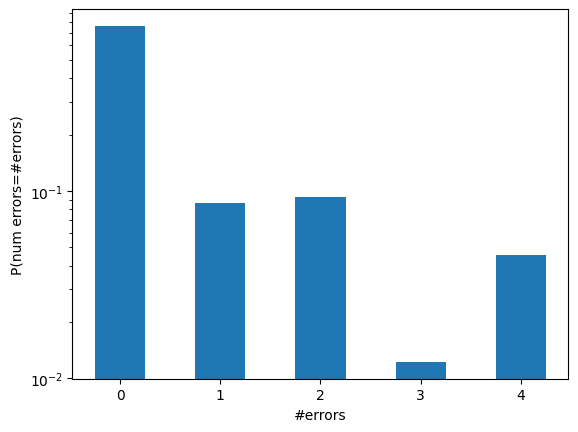

In [2]:
cat_state = circ.copy()
cat_state.append_operation("MR", range(8))

n_samples = 1000000
sampler = cat_state.compile_sampler()
samples = sampler.sample(n_samples).astype(int)

error_weights = np.min(np.vstack((samples.sum(axis=1), 8 - samples.sum(axis=1))), axis=0) # at most 4 bits can flipe
hist, bins = np.histogram(error_weights, bins=range(4 + 2))

# Compute bin centers from the bin edges
bin_centers = (0.5 * (bins[:-1] + bins[1:]))-.5

# Create a bar plot with a width of 1 (adjust if needed)
plt.bar(bin_centers, hist/n_samples, width=.5, align='center')
plt.xlabel("#errors")
plt.ylabel("P(num errors=#errors)")
plt.yscale('log')
plt.show()

We see that 1,2 and 4 errors occur on the order of the physical error rate, which we set to $p = 0.05$. Interestingly, 3 errors occur only with a probability of about $p^2$. This is due to the structure of the circuit. If an $X$ error occurs, it either propagates to one or two CNOTs, or it doesn't propagate at all. Three errors are caused by a propagated error and another single-qubit error.

## First Attempt at Fault-tolerant Preparation

Since the cat-state is CSS, it admits a transversal CNOT. Therefore, we could try to copy the errors of one cat state to another cat state, measure out the qubits of the ancilla state and if we find that an error occured we restart. Let us do just that now.

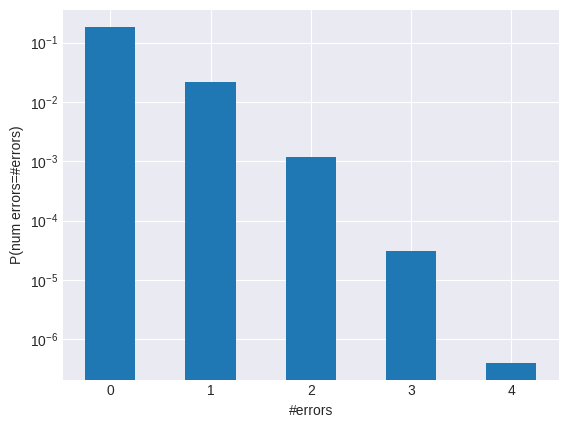

Proportion of accepted runs: 0.2084106


In [22]:
ancilla = stim.Circuit()

# define the ancilla state on qubits 8 to 15
ancilla.append_operation("H", [8])
ancilla.append_operation("DEPOLARIZE1", [8], p)

noisy_cnot(ancilla, 8, 12, p)

noisy_cnot(ancilla, 8, 10, p)
noisy_cnot(ancilla, 12, 14, p)

noisy_cnot(ancilla, 8, 9, p)
noisy_cnot(ancilla, 10, 11, p)
noisy_cnot(ancilla, 12, 13, p)
noisy_cnot(ancilla, 14, 15, p)

combined = circ + ancilla

# perform the transversal cnot
combined.append_operation("CX", [q for tup in zip(range(8), range(8,16)) for q in tup])
combined.append_operation("DEPOLARIZE2", [q for tup in zip(range(8), range(8,16)) for q in tup], p)
combined.append_operation("X_ERROR", range(8,16), p) # noisy measurements on ancilla

# measure out all the qubits
# note that in a real circuit we wouldn't measure out the "data" cat state
combined.append_operation("MR", range(16)) 

def run_experiment(combined_circuit: stim.Circuit) -> None:
    n_samples = 5000000 
    sampler = combined_circuit.compile_sampler()
    samples = sampler.sample(n_samples).astype(int)
    
    # filter out all runs where the ancilla state was faulty
    anc = samples[:, 8:]
    filtered = np.where(np.logical_or(np.all(anc == 1, axis=1), np.all(anc == 0, axis=1)))[0] 
    state = samples[filtered, :8]
    accepted = state.shape[0]
    
    error_weights = np.min(np.vstack((state.sum(axis=1), 8 - state.sum(axis=1))), axis=0) # at most 4 bits can flipe
    hist, bins = np.histogram(error_weights, bins=range(4 + 2))
    
    # Compute bin centers from the bin edges
    bin_centers = (0.5 * (bins[:-1] + bins[1:]))-.5
    
    # Create a bar plot with a width of 1 (adjust if needed)
    plt.bar(bin_centers, hist/n_samples, width=.5, align='center')
    plt.xlabel("#errors")
    plt.ylabel("P(num errors=#errors)")
    plt.yscale('log')
    plt.show()
    
    print(f"Proportion of accepted runs: {accepted/n_samples}")

run_experiment(combined)

Now what is happening here? We see that the two-qubit errors happen with probability of about $p^2$ and the three-qubit errors happen with probability of about $p^3$. But it seems that four-qubit errors on accepted states appear with a probability of $p^2$ instead of $p^4$ which we are aiming for. 

This is because in the constructions, there are propagated weight-four errors that are cancelled on the ancilla by two more errors. Here is a [crumble circuit](https://algassert.com/crumble#circuit=Q(0,0)0;Q(1,0)1;Q(2,0)2;Q(3,0)3;Q(4,0)4;Q(5,0)5;Q(6,0)6;Q(7,0)7;Q(8,0)8;Q(9,0)9;Q(10,0)10;Q(11,0)11;Q(12,0)12;Q(13,0)13;Q(14,0)14;Q(15,0)15;H_0_8;TICK;TICK;CX_0_4_8_12;TICK;MARKX(0)0;TICK;CX_0_2_4_6_8_10_12_14;TICK;MARKX(0)10_8;TICK;CX_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15;TICK;TICK;CX_0_8_1_9_2_10_3_11_4_12_5_13_6_14_7_15;TICK;TICK;TICK;MR_0_1_2_3_4_5_6_7_8_9_10_11_12_13_14_15) that visualizes one of these cases.

## Second Attempt at Fault-Tolerant State Preparation
The problem in the previous construction is that both circuits propagate errors in the same way. We can try to fix this in one of two ways:

- Prepare the ancilla with a different circuit.
- Permute the transversal CNOTs.

The second case is actually a special case of the first one. Permuting how qubits are connected via the transversal CNOT is equivalent to permuting the CNOTs in the ancilla preparation circuit. But let's approach this one first, since it is conceptually simpler. We want to find a permutation such that no errors cancel each other out anymore. Looking at the circuit, one idea is to swap qubits such that all sub-trees in the CNOT trees in the two circuits are similar. One permutation that achieves this is 
$$(0\quad 7)$$

Let's see how it performs.

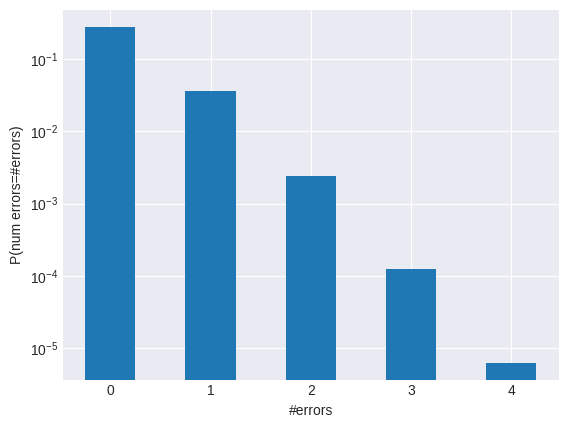

Proportion of accepted runs: 0.3218154


In [101]:
combined = circ + ancilla

# perform the transversal cnot
combined.append_operation("CX", [0,15,1,9,2,13,3,11, 4,12,5,10,6,14,7,8])
combined.append_operation("DEPOLARIZE2", [0,15,1,9,2,10,3,11, 4,12,5,13,6,14,7,8], p)
combined.append_operation("X_ERROR", range(8,16), p) # noisy measurements on ancilla

# measure out all the qubits
# note that in a real circuit we wouldn't measure out the "data" cat state
combined.append_operation("MR", range(8))
combined.append("TICK")
combined.append_operation("MR", range(8, 16))


run_experiment(combined)

It worked! And it doesn't even come at the cost of a lower acceptance rate. 

So, the question is: **Is there a general permutation $\sigma$ that makes this procedure fault-tolerant for arbitrary $w$?**

We can try to generalize this with some functionality in `mqt.qecc`:

In [92]:
# Change this function and run the cell below to test how it impacts the performance for w=8,16,32
def ft_perm(w:int) -> list[int]:
    """Return the ft permutation for a given number of qubits.

    Args:
        w: The number of qubits.
    Returns:
        The recursive permutation
    """
    return np.arange(w).reshape((w//4, 4)).T.reshape(w)
    

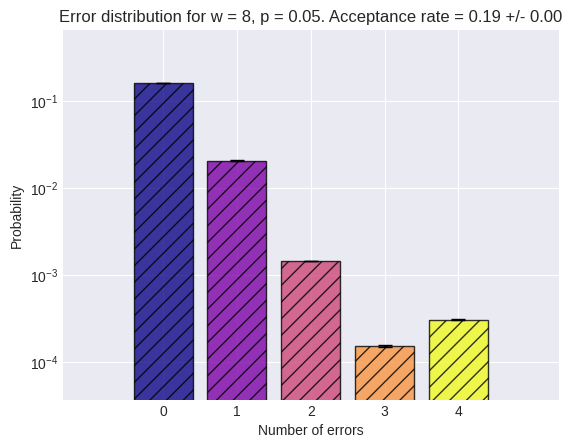

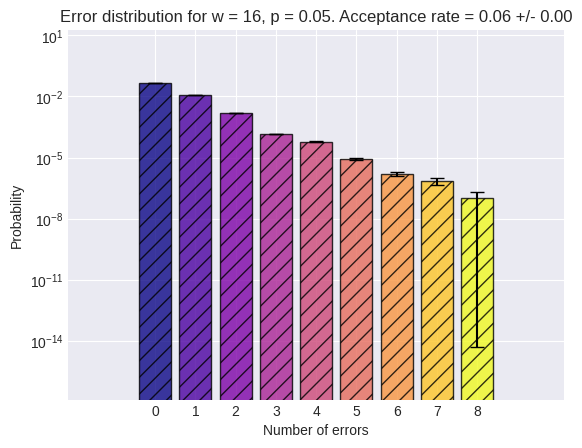

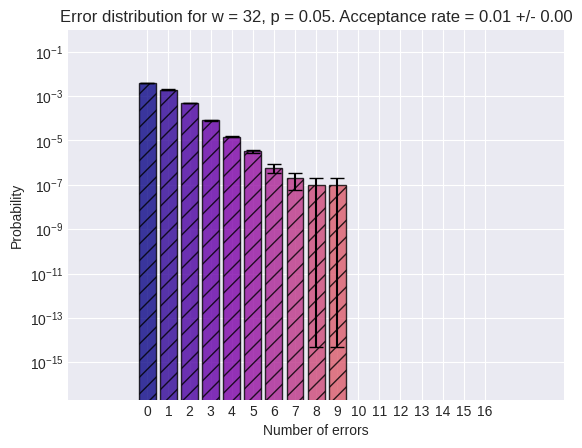

In [81]:
from mqt.qecc.circuit_synthesis.cat_states import cat_state_balanced_tree, CatStatePreparationExperiment
w = 8
circ = cat_state_balanced_tree(w)
experiment = CatStatePreparationExperiment(circ, circ, ft_perm(w))
experiment.plot_one_p(0.05, n_samples=10000000)

w = 16
circ = cat_state_balanced_tree(w)
experiment = CatStatePreparationExperiment(circ, circ, ft_perm(w))
experiment.plot_one_p(0.05, n_samples=10000000)

w = 32
circ = cat_state_balanced_tree(w)
experiment = CatStatePreparationExperiment(circ, circ, ft_perm(w))
experiment.plot_one_p(0.05, n_samples=10000000)

Maybe the circuits are too similar in general. We can try to construct the circuits in a different way such that the errors propagate in a different manner. This comes at the cost of higher depth. Let's try the following circuit, which is constructed such that it only has weight one, two or three faults.

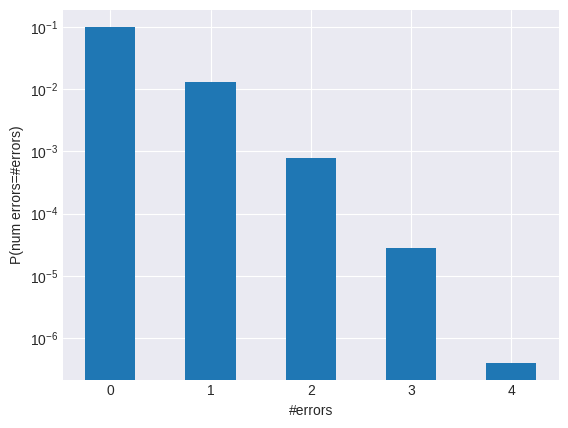

Proportion of accepted runs: 0.1143144


In [91]:
ancilla = stim.Circuit()

# define the ancilla state on qubits 8 to 15
ancilla.append("H", [8])
ancilla.append("DEPOLARIZE1", [8], p)

noisy_cnot(ancilla, 8, 10, p)

noisy_cnot(ancilla, 8, 14, p)

noisy_cnot(ancilla, 11, 13, p)

noisy_cnot(ancilla, 8, 11, p)

noisy_cnot(ancilla, 8, 9, p)
noisy_cnot(ancilla, 11, 12, p)
noisy_cnot(ancilla, 14, 15, p)

combined = circ + ancilla

combined.append_operation("CX", [q for tup in zip(range(8), range(8,16)) for q in tup])
combined.append_operation("DEPOLARIZE2", [q for tup in zip(range(8), range(8,16)) for q in tup], p)
combined.append_operation("X_ERROR", range(8,16), p) # noisy measurements on ancilla
# perform the transversal cnot
combined.append_operation("MR", range(8))
combined.append("TICK")
combined.append_operation("MR", range(8, 16))


run_experiment(combined)

This already works for $w=8$. The reason this work is a little bit more intricate than the weights of the fault sets. Since a weight-three and a weight-one fault already combine to a weight-4 fault, they might cancel with a weight-4 fault from the other circuit. Therefore, it matters again how the CNOTs are connected. In the case where this fails, we can permute the CNOTs again.

So the second question is: **If there is no general permutation to make the previous circuit fault-tolerant, is there a second preparation circuit structure (combined with a permutation) that renders the preparation fault-tolerant for arbitrary $w$?**

## Playground for Testing out Stuff




In [102]:
from mqt.qecc.circuit_synthesis.cat_states import cat_state_balanced_tree, CatStatePreparationExperiment, ft_perm, cat_state_line

w = 16
circ = cat_state_balanced_tree(w)
circ2 = cat_state_balanced_tree(w)
#permutation = np.random.permutation(np.arange(16))
#permutation[[0,2,4,6, 8,10,12,14]] = permutation[[8,10,12,14,0,2,4,6]]
#permutation[[1,2, 5,6, 8,9, 12,13]] = permutation[[8,9, 12,13, 1,2, 5,6,]]
#permutation[[2,3,4,5, 8,9,10,11]] = permutation[[8,9,10,11,2,3,4,5, ]]
permutation = np.array([12, 10,  1, 13,  6,  4,  2,  9,  5, 15, 11,  8,  0,  7, 14,  3]) # determined by sampling
experiment = CatStatePreparationExperiment(circ, circ2, permutation)
experiment.plot_one_p(0.05, n_samples=5000000000, batch_size=100000)

KeyboardInterrupt: 

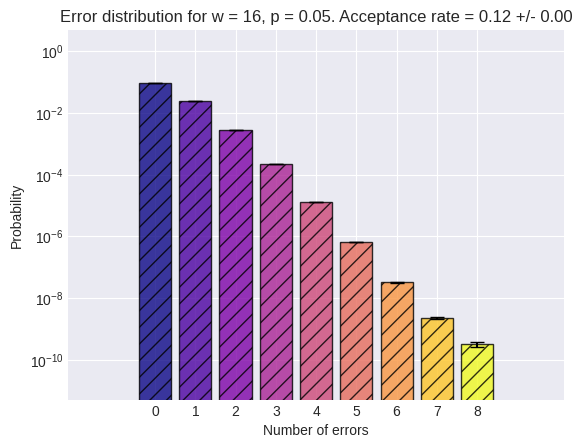

In [116]:
from mqt.qecc.circuit_synthesis.cat_states import cat_state_balanced_tree, CatStatePreparationExperiment, cat_state_line

w = 16
circ = cat_state_balanced_tree(w)
circ2 = cat_state_balanced_tree(w)
permutation = np.arange(w)

permutation = [12, 5, 9, 2, 6, 13, 14, 1, 3, 7, 15, 10, 0, 8, 4, 11]

experiment = CatStatePreparationExperiment(circ, circ2, permutation)
experiment.plot_one_p(.05, n_samples=100000000000, batch_size=1000000)

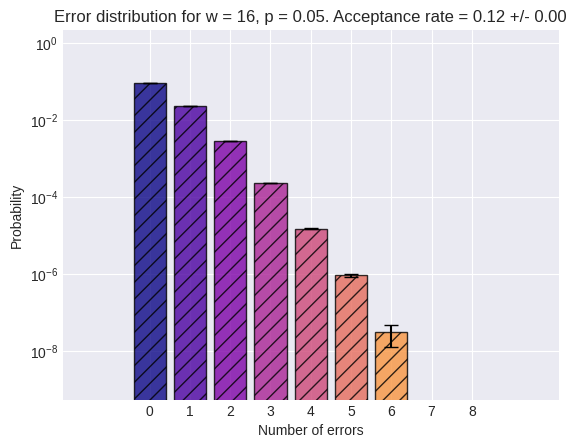

In [137]:
from mqt.qecc.circuit_synthesis.cat_states import cat_state_balanced_tree, CatStatePreparationExperiment, cat_state_line

w = 16
circ = cat_state_balanced_tree(w)
circ2 = cat_state_balanced_tree(w)
permutation = np.arange(w)

permutation = [0, 1, 6, 10, 13, 3, 5, 15, 2, 8, 11, 14, 4, 9, 12, 7]

experiment = CatStatePreparationExperiment(circ, circ2, permutation)
experiment.plot_one_p(.05, n_samples=100000000, batch_size=1000000)

In [135]:
from mqt.qecc.circuit_synthesis.cat_states import cat_state_balanced_tree, CatStatePreparationExperiment, cat_state_line

w = 16
circ = cat_state_balanced_tree(w)
circ2 = cat_state_balanced_tree(w)
permutation = np.arange(w)

permutation = [0, 1, 6, 10, 13, 3, 5, 15, 2, 8, 11, 14, 4, 9, 12, 7]

experiment = CatStatePreparationExperiment(circ, circ2, permutation)

In [136]:
experiment.circ.to_crumble_url()

'https://algassert.com/crumble#circuit=H_0;CX_0_8_0_4_0_2_0_1_2_3_4_6_4_5_6_7_8_12_8_10_8_9_10_11_12_14_12_13_14_15;H_16;CX_16_24_16_20_16_18_16_17_18_19_20_22_20_21_22_23_24_28_24_26_24_25_26_27_28_30_28_29_30_31_0_16_1_17_2_22_3_26_4_29_5_19_6_21_7_31_8_18_9_24_10_27_11_30_12_20_13_25_14_28_15_23;MR_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31'

In [143]:
inverse = [None for i in range(len(permutation))]
for i, j in enumerate(permutation):
    inverse[j] = i
inverse

[0, 1, 8, 5, 12, 6, 2, 15, 9, 13, 3, 10, 14, 4, 11, 7]